Notebook for the continuation of this project after Summer 2023

Author: Daniel Fu

Created: 12/22/2023

Some sections copied from `optim.ipynb`

# Setup

In [1]:
from g4beam import *
from scan import *

import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import numpy as np
import pandas as pd
from tqdm import *
import pickle
import itertools
from tabulate import tabulate
import scipy.optimize
import lzma

In [3]:
# Run this cell to reload g4beam.py
from importlib import reload
import g4beam
reload(g4beam)
from g4beam import *

In [2]:
# Parameter list
PARAMS = [
    "t_emit",
    "momentum",
    "beta",
    "alpha",
    "l_emit",
    "pz_std",
    "vd_dist",
    "w1_length",
    "w1_angle",
    "w2_length",
    "w2_angle",
    "drift_length",
    "rf_freq",
    "rf_phase",
    "rf_length",
    "rf_grad"
]

def load_params(filename):
    with open(filename, "rb+") as file:
        parameters = pickle.load(file)
        globals().update(parameters)
        print("Loaded from", filename)

## Useful cells

In [4]:
# View parameter set
filename = "results/parameters/"+input("Enter run name to view: ")+".pkl"
with open(filename, "rb+") as file:
    parameters = pickle.load(file)
    print("Viewing", filename)
    print(*[x + " = " + str(parameters[x]) for x in parameters], sep="\n")

Enter run name to view:  145_new


Viewing results/parameters/145_new.pkl
t_emit = 0.145
momentum = 100
beta = 0.03
alpha = 0.7
l_emit = 1
pz_std = 1
vd_dist = 24
w1_length = 7.501906369754579
w1_angle = 46.538398375036195
w2_length = 6.06795178364264
w2_angle = 40.7958152059
drift_length = 16000
rf_freq = 0.025
rf_phase = 0.0002612734499101793
rf_length = 5589.183462571583
rf_grad = 5.143547111719555


# Statistical variation in wedge

With a typical set of parameters, how much uncertainty in the emittances after the first wedge is introduced by the random generation of distributions?

In [42]:
Ns = [12000, 20000, 50000]

In [ ]:
load_params("results/parameters/145_new.pkl")
results_1 = list()
for N in Ns:
    res = list()
    for _ in trange(30):
        pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=N)
        pre_w1["PDGid"] = -13
        post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
        res.append(calc_all_params(post_w1))
    results_1.append(res)

Raw errors:
    N       xemit        yemit      zemit
-----  ----------  -----------  ---------
12000  0.00372188  0.00168243   0.0670395
20000  0.00246957  0.00160364   0.0474612
50000  0.00140033  0.000684377  0.0318515

Percent errors:
    N    xemit    yemit    zemit
-----  -------  -------  -------
12000    7.99%    1.11%    1.06%
20000    5.34%    1.06%    0.75%
50000    3.00%    0.45%    0.50%


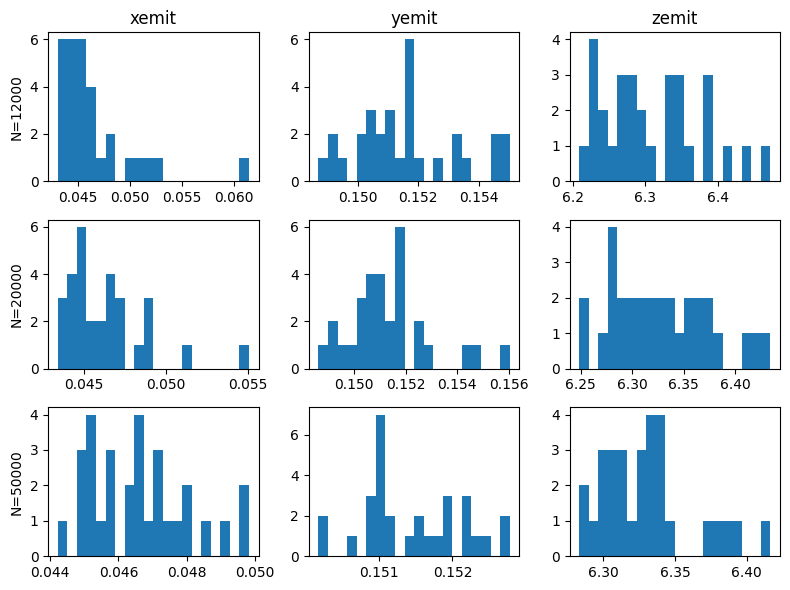

In [55]:
emits = np.array([list(zip(*[[x[0][0], x[1][0], x[2]] for x in y])) for y in results_1])

fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(8, 6)
labels = ["xemit", "yemit", "zemit"]

for axrow, row in zip(axs, emits):
    for ax, data in zip(axrow, row):
        ax.hist(data, bins=20)

for ax, N in zip(axs[:,0], Ns):
    ax.set_ylabel(f"N={N}")

for ax, label in zip(axs[0], labels):
    ax.set_title(label, size='large')

fig.tight_layout()

print("Raw errors:")
print(tabulate([[N] + [np.std(y) for y in x] for N, x in zip(Ns, emits)], headers=["N"] + labels))

print("\nPercent errors:")
print(tabulate([[N] + [np.std(y)/np.mean(y) for y in x] for N, x in zip(Ns, emits)], headers=["N"] + labels, floatfmt=".2%"))

Repeating with more trials in the lowest case (`N=12000`) to better obtain the distributions

In [56]:
load_params("results/parameters/145_new.pkl")
results_1_1 = list()
for _ in trange(300):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
    pre_w1["PDGid"] = -13
    post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
    results_1_1.append(calc_all_params(post_w1))

Loaded from results/parameters/145_new.pkl


100%|████████████████████████████████████████████████████████████████████████████| 300/300 [30:46<00:00,  6.15s/it]


Raw errors:
xemit: 0.0030433588129797624
yemit: 0.0018148192985439732
zemit: 0.06357365978011867
xbeta: 0.0009529027733206144

Percent errors:
xemit: 6.55%
yemit: 1.20%
zemit: 1.00%
xbeta: 2.73%


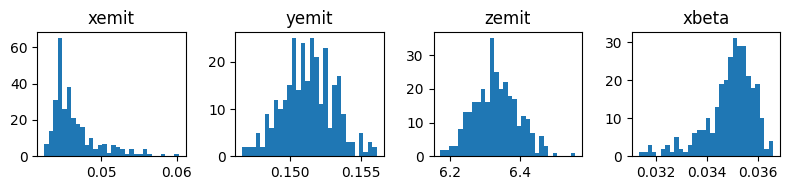

In [60]:
values = np.array(list(zip(*[[x[0][0], x[1][0], x[2], x[0][1]] for x in results_1_1])))

fig, axs = plt.subplots(ncols=4)
fig.set_size_inches(8, 2)
labels = ["xemit", "yemit", "zemit", "xbeta"]

for ax, data, label in zip(axs, values, labels):
    ax.hist(data, bins=30)
    ax.set_title(label, size='large')

fig.tight_layout()

print("Raw errors:", *[f"{l}: {np.std(x)}" for l, x in zip(labels, values)], sep="\n")
print("\nPercent errors:", *[f"{l}: {np.std(x)/np.mean(x):.2%}" for l, x in zip(labels, values)], sep="\n")

Adding a 4-sigma cut to see if that changes the distribution. Also recording transmission on these runs

In [61]:
load_params("results/parameters/145_new.pkl")
results_1_2 = list()
for _ in trange(300):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
    pre_w1["PDGid"] = -13
    post_w1 = cut_outliers(run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0))
    results_1_2.append(list(calc_all_params(post_w1)) + [len(post_w1)/len(pre_w1)])

Loaded from results/parameters/145_new.pkl


100%|████████████████████████████████████████████████████████████████████████████| 300/300 [31:33<00:00,  6.31s/it]


Raw errors:
xemit: 0.0005365421316420945
yemit: 0.0014358186493473308
zemit: 0.057839944413835144
xbeta: 0.00042857058055285077
T: 0.0004156840264871193

Percent errors:
xemit: 1.27%
yemit: 0.97%
zemit: 0.94%
xbeta: 1.19%
T: 0.04%


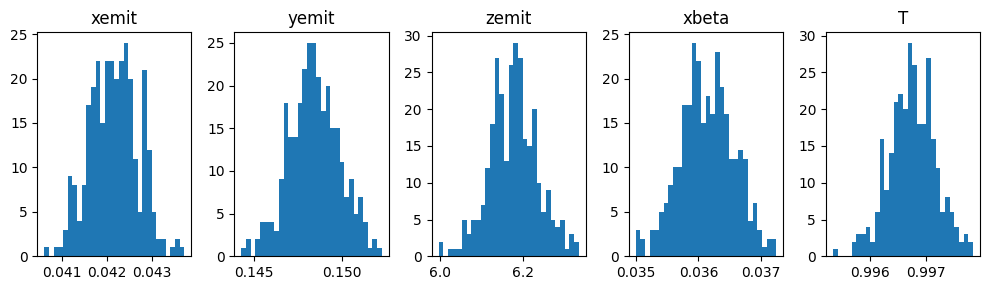

In [63]:
values = np.array(list(zip(*[[x[0][0], x[1][0], x[2], x[0][1], x[3]] for x in results_1_2])))

fig, axs = plt.subplots(ncols=5)
fig.set_size_inches(10, 3)
labels = ["xemit", "yemit", "zemit", "xbeta", "T"]

for ax, data, label in zip(axs, values, labels):
    ax.hist(data, bins=30)
    ax.set_title(label, size='large')

fig.tight_layout()

print("Raw errors:", *[f"{l}: {np.std(x)}" for l, x in zip(labels, values)], sep="\n")
print("\nPercent errors:", *[f"{l}: {np.std(x)/np.mean(x):.2%}" for l, x in zip(labels, values)], sep="\n")

Removing the outliers significantly decreases the variation and makes the distributions symmetric. Redoing the first set of runs with this as well

In [64]:
Ns = [12000, 20000, 50000]

In [65]:
load_params("results/parameters/145_new.pkl")
results_1_3 = list()
for N in Ns:
    res = list()
    for _ in trange(30):
        pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=N)
        pre_w1["PDGid"] = -13
        post_w1 = cut_outliers(run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0))
        res.append(list(calc_all_params(post_w1)) + [len(post_w1)/len(pre_w1)])
    results_1_3.append(res)

Loaded from results/parameters/145_new.pkl


100%|██████████████████████████████████████████████████████████████████████████████| 30/30 [12:15<00:00, 24.51s/it]


Raw errors:
    N        xemit        yemit      zemit            T
-----  -----------  -----------  ---------  -----------
12000  0.000551538  0.00162552   0.054245   0.000354915
20000  0.000425036  0.000874624  0.0492254  0.000303516
50000  0.000247991  0.000600126  0.0275174  0.000211958

Percent errors:
    N    xemit    yemit    zemit      T
-----  -------  -------  -------  -----
12000    1.30%    1.09%    0.88%  0.04%
20000    1.01%    0.59%    0.80%  0.03%
50000    0.59%    0.40%    0.45%  0.02%


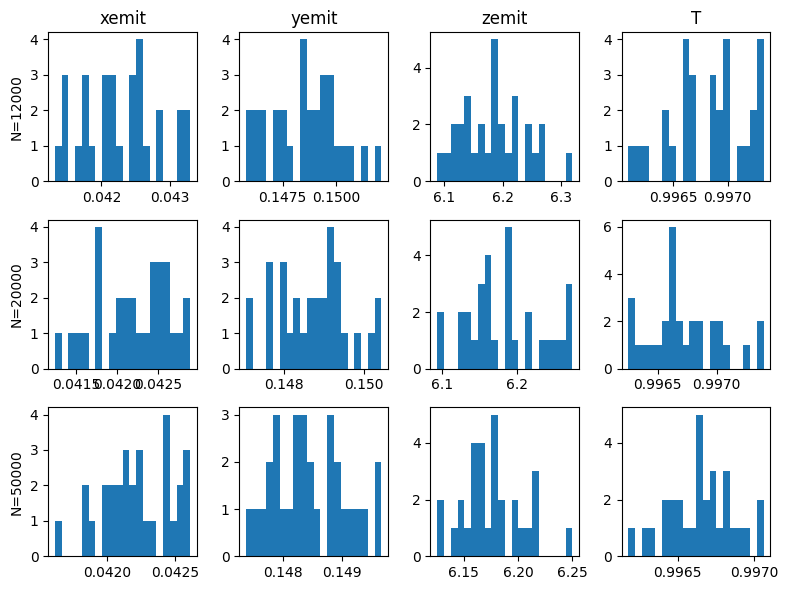

In [67]:
emits = np.array([list(zip(*[[x[0][0], x[1][0], x[2], x[3]] for x in y])) for y in results_1_3])

fig, axs = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(8, 6)
labels = ["xemit", "yemit", "zemit", "T"]

for axrow, row in zip(axs, emits):
    for ax, data in zip(axrow, row):
        ax.hist(data, bins=20)

for ax, N in zip(axs[:,0], Ns):
    ax.set_ylabel(f"N={N}")

for ax, label in zip(axs[0], labels):
    ax.set_title(label, size='large')

fig.tight_layout()

print("Raw errors:")
print(tabulate([[N] + [np.std(y) for y in x] for N, x in zip(Ns, emits)], headers=["N"] + labels))

print("\nPercent errors:")
print(tabulate([[N] + [np.std(y)/np.mean(y) for y in x] for N, x in zip(Ns, emits)], headers=["N"] + labels, floatfmt=".2%"))

In [70]:
# Save the data just in case
with open("results/repeated_trial_variation.pkl", "wb+") as file:
    pickle.dump((results_1, results_1_1, results_1_2, results_1_3), file)

## Variation in optimization

As an addendum, how much variation in the results of an optimization on the length and half-angle for the first wedge is introduced by random generation?

**This project has been moved to `accuracy.py` and `accuracy.ipynb`. The code below is unfinished.**

In [247]:
load_params("results/parameters/145_new.pkl")
# results_varopt_x = 

# for _ in range(10):
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
def func(x):
    length, angle = x
    return emittances(cut_outliers(run_distribution(pre_w1, length, angle, vd_dist, axis=0)))[0]

%time scipy.optimize.minimize(func, [7.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=2e-4))

Loaded from results/parameters/145_new.pkl
CPU times: total: 7.7 s
Wall time: 25min 45s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.04168482611824361
             x: [ 7.173e+00  4.781e+01]
           nit: 28
          nfev: 71
 final_simplex: (array([[ 7.173e+00,  4.781e+01],
                       [ 7.173e+00,  4.781e+01],
                       [ 7.173e+00,  4.781e+01]]), array([ 4.168e-02,  4.169e-02,  4.170e-02]))

In [11]:
beta, alpha, t_emit, momentum, pz_std, l_emit, w1_length, w1_angle, vd_dist

(0.03, 0.7, 0.145, 100, 1, 1, 7.501906369754579, 46.538398375036195, 24)

In [36]:
load_params("results/parameters/145_new.pkl")
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
pre_w1["PDGid"] = -13
%time post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0, maxStep=1.5)
print_all_params(post_w1)
post_w1

Loaded from results/parameters/145_new.pkl
CPU times: total: 62.5 ms
Wall time: 3.87 s
-----------------------------
Twiss parameters for X
emit  = 0.04488586003663708 mm
beta  = 0.03490987471056999 m
gamma = 195.28292358229575 1/m
alpha = -2.411908455014775
D     = 0.0202821807125479 m
D'    = -0.0228553312625227

Twiss parameters for Y
emit  = 0.15000507922868614 mm
beta  = 0.025660192999096047 m
gamma = 58.8677381017286 1/m
alpha = -0.7145330790877326
D     = 0.0003777380150904022 m
D'    = 0.019692644596707876

Z-emittance:  6.2918372935085864 mm
Z std: 141.3912634716308 mm
p std: 7.176569824038617 MeV/c
Mean momentum: 87.25613564291939 MeV/c
-----------------------------


,x,y,z,Px,Py,Pz,t,PDGid,EventID,TrackID,...,ProperTime,PathLength,PolX,PolY,PolZ,InitX,InitY,InitZ,InitT,InitKE
0,-1.499070,0.166597,25,-4.197510,-2.88435,83.0329,1.047400,-13,1,1,...,0.097308,25.0513,0,0,0,-0.125866,0.134525,0,0.919042,39.5352
1,-0.535117,-1.373310,25,-0.926791,-7.47339,89.8117,-0.728342,-13,2,1,...,0.092646,25.0843,0,0,0,0.002219,0.529417,0,-0.853222,40.7879
2,-1.417310,-2.308530,25,1.396920,-5.82548,78.7483,0.676245,-13,3,1,...,0.100159,25.0508,0,0,0,-1.998250,-0.946108,0,0.545655,39.8779
3,2.303430,0.486040,25,10.858000,-9.95457,89.1553,0.452985,-13,4,1,...,0.094157,25.2207,0,0,0,-0.267190,2.400230,0,0.326689,39.4874
4,-1.753880,-2.550660,25,-20.846300,-12.27590,87.3711,-0.977779,-13,5,1,...,0.095972,25.6916,0,0,0,3.441160,0.120058,0,-1.106470,38.6563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.099708,1.853360,25,4.571790,5.80957,85.0291,0.348888,-13,11996,1,...,0.096265,25.0455,0,0,0,-0.391388,1.211540,0,0.221358,39.3444
11996,4.071510,1.423530,25,-1.993930,8.20077,100.7040,-1.227370,-13,11997,1,...,0.087494,25.0876,0,0,0,4.566510,-0.612325,0,-1.348440,40.5477
11997,-3.574980,-2.158610,25,-10.609300,-6.46057,73.5798,-1.507760,-13,11998,1,...,0.104529,25.2732,0,0,0,-0.621539,-0.110137,0,-1.642230,37.6682
11998,-1.239810,1.526800,25,1.542110,1.36365,84.1192,-0.165557,-13,11999,1,...,0.096300,25.0636,0,0,0,-0.171993,1.374190,0,-0.293171,39.8634


In [ ]:
results = list() # Comment out to add to already created list
load_params("results/parameters/145_new.pkl")
for _ in range(10):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=N)
    def func(x):
        length, angle = x
        return emittances(cut_outliers(run_distribution(pre_w1, length, angle, vd_dist, axis=0)))[0]
    res = scipy.optimize.minimize(func, [7.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=2e-4))
    results.append((res.x[0]. res.x[1], res.func))
results = np.swapaxes(np.array(results), 0, 1)
with open("results/repeated_optimization_variation.pkl", "wb+") as file:
    pickle.dump(results, file)

# Surface of optimality for wedge

**I've abandoned this project for now**

Attempting to precisely characterize the "curved optimal valley" seen on 2D scans. I compute optimal RF gradient as a function of RF frequency and RF cavity length.

## Preliminary tests

### Single run

Checking how long a single run takes:

In [162]:
%%time
# Test cell: rf length, rf freq, and rf grad must be iterated over
rf_length = 5580
rf_freq = 0.025

drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(post_correct, drift_to_start))
pre_cavity = remove_transverse(post_drift)
post_cavity = cut_pz(recenter_t(run_g4beam(pre_cavity, "G4_RFCavity.g4bl",
                                           RF_length=rf_length,
                                           frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad,
                                           nparticles=len(pre_cavity))), tails=0.15)
np.std(post_cavity["Pz"])

CPU times: total: 172 ms
Wall time: 35.5 s


0.9588748762733945

### Curves v.s. gradient

Showing the sigma-z v.s. grad curve for a single choice of length and freq. I graph it several times to determine the degree of variability from generation of the initial distribution.

In [164]:
rf_grads = np.linspace(1, 8, 30)

In [169]:
results_2_pre = list()

In [174]:
load_params("results/parameters/145_new.pkl")
drift_to_start = drift_length-rf_length/2
for _ in range(2):
    res = list()
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
    pre_w1["PDGid"] = -13
    post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
    pre_drift = remove_dispersion(post_w1)
    pre_drift["Px"] *= -1
    pre_drift["Py"] *= -1
    post_drift = recenter_t(z_prop(pre_drift, drift_to_start))
    pre_cavity = remove_transverse(post_drift)
    for rf_grad in tqdm(rf_grads):        post_cavity = cut_pz(recenter_t(run_g4beam(pre_cavity, "G4_RFCavity.g4bl",
                                                   RF_length=rf_length,
                                                   frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad,
                                                   nparticles=len(pre_cavity))), tails=0.15)
        res.append(np.std(post_cavity["Pz"]))
    results_2_pre.append(np.array(res))

Loaded from results/parameters/145_new.pkl


100%|██████████████████████████████████████████████████████████████████████████████| 30/30 [10:50<00:00, 21.67s/it]


Text(0, 0.5, '$\\sigma pz$ (MeV/c)')

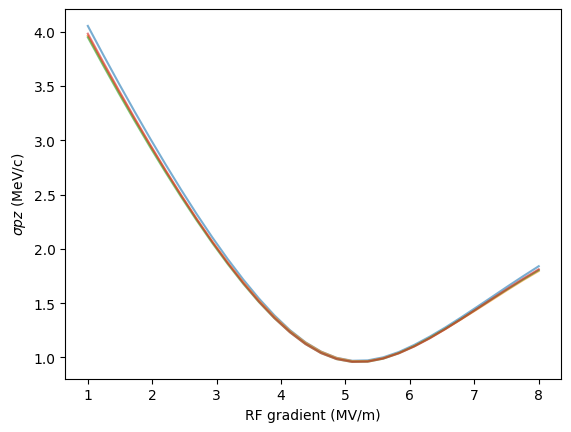

In [178]:
fig, ax = plt.subplots()
for res in results_2_pre:
    ax.plot(rf_grads, res, alpha=0.6)
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel(r"$\sigma pz$ (MeV/c)")

Run the above graph again with fewer particles to see if a lower-N simulation can produce accurate results

In [186]:
results_2_pre_2 = list()

In [188]:
load_params("results/parameters/145_new.pkl")
drift_to_start = drift_length-rf_length/2
for _ in range(4):
    res = list()
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=6000)
    pre_w1["PDGid"] = -13
    post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
    pre_drift = remove_dispersion(post_w1)
    pre_drift["Px"] *= -1
    pre_drift["Py"] *= -1
    post_drift = recenter_t(z_prop(pre_drift, drift_to_start))
    pre_cavity = remove_transverse(post_drift)
    for rf_grad in tqdm(rf_grads):
        post_cavity = cut_pz(recenter_t(run_g4beam(pre_cavity, "G4_RFCavity.g4bl",
                                                   RF_length=rf_length,
                                                   frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad,
                                                   nparticles=len(pre_cavity))), tails=0.15)
        res.append(np.std(post_cavity["Pz"]))
    results_2_pre_2.append(np.array(res))

Loaded from results/parameters/145_new.pkl


100%|██████████████████████████████████████████████████████████████████████████████| 30/30 [05:41<00:00, 11.40s/it]


Text(0, 0.5, '$\\sigma pz$ (MeV/c)')

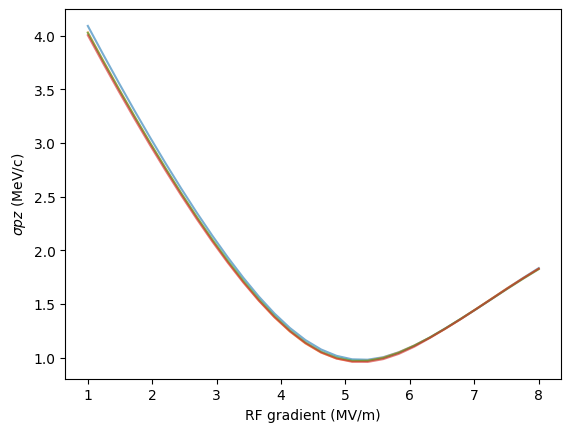

In [189]:
fig, ax = plt.subplots()
for res in results_2_pre_2:
    ax.plot(rf_grads, res, alpha=0.6)
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel(r"$\sigma pz$ (MeV/c)")

In [202]:
results_2_pre_2 = np.array(results_2_pre_2)
np.ptp(results_2_pre_2, axis=0)/np.mean(results_2_pre_2, axis=0)

array([0.02150577, 0.02213792, 0.02281253, 0.0234159 , 0.02404881,
       0.02461756, 0.02517611, 0.02564763, 0.0260858 , 0.02626505,
       0.02606349, 0.02522536, 0.02465038, 0.02646633, 0.02742978,
       0.02780274, 0.02540357, 0.02369545, 0.02130587, 0.01804847,
       0.01482791, 0.01022889, 0.00386876, 0.00248163, 0.00215458,
       0.00150767, 0.00252321, 0.00365789, 0.00443418, 0.00540553])

Graph this curve for other values of RF length and frequency to make sure our parameter space is reasonable

In [233]:
results_2_pre_3 = list()

In [234]:
rf_grads = np.linspace(1, 8, 30)

In [236]:
load_params("results/parameters/145_new.pkl")
lengths_and_freqs = [
    (2000, 0.015),
    (2000, 0.035),
    (6000, 0.015),
    (6000, 0.035)
]

pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=6000)
pre_w1["PDGid"] = -13
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
pre_drift = remove_dispersion(post_w1)
pre_drift["Px"] *= -1
pre_drift["Py"] *= -1

for rf_length, rf_freq in lengths_and_freqs:
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(pre_drift, drift_to_start))
    pre_cavity = remove_transverse(post_drift)
    
    res = list()
    for rf_grad in tqdm(rf_grads):
        post_cavity = cut_pz(recenter_t(run_g4beam(pre_cavity, "G4_RFCavity.g4bl",
                                                   RF_length=rf_length,
                                                   frfcool=rf_freq, ficool=0, Vrfcool=rf_grad,
                                                   nparticles=len(pre_cavity))), tails=0.15)
        res.append(np.std(post_cavity["Pz"]))
    res = np.array(res)
    results_2_pre_3.append((rf_length, rf_freq, res))

Loaded from results/parameters/145_new.pkl


100%|██████████████████████████████████████████████████████████████████████████████| 30/30 [05:52<00:00, 11.77s/it]


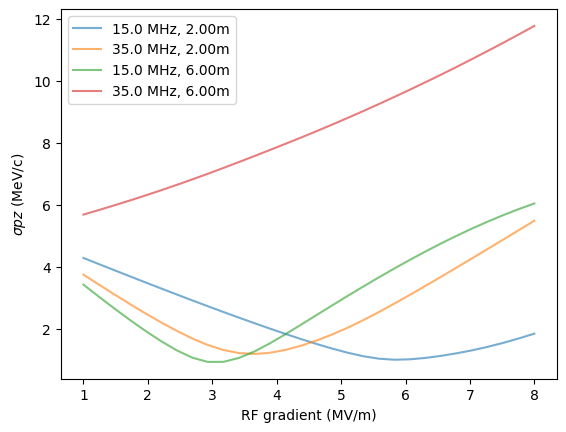

In [237]:
fig, ax = plt.subplots()
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel(r"$\sigma pz$ (MeV/c)")
for rf_length, rf_freq, res in results_2_pre_3:
    ax.plot(rf_grads, res, alpha=0.6, label=f"{rf_freq*1000:.1f} MHz, {rf_length/1000:.2f}m")
ax.legend()

There are some combinations of frequency/length where there is no optimum at all. This can also be seen on the earlier 2D contour plots (the optimal valley "curves away" and becomes vertical at some point).

Note: G4Beamline crashes with an "Iteration Limit" exception in some cases where gradient, frequency, and length are all high. This indicates that the RF phase tuning has failed to converge. I'm unsure why this exception occurs and I'm working on figuring it out. An example of parameters that trigger it is given below:

`g4bl G4_RFCavity.g4bl beamfile=in_1703654430_62183.txt outname=out_1703654430_62183 RF_length=6000 frfcool=0.035 ficool=0 Vrfcool=9 nparticles=6000`

### Single optimization run

Check how long a single optimization run will take

In [200]:
# Demonstration of a single 1D optimization: preparation part
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=6000)
pre_w1["PDGid"] = -13
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
pre_drift = remove_dispersion(post_w1)
pre_drift["Px"] *= -1
pre_drift["Py"] *= -1

print(rf_length, rf_freq) # Iterate over these

drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(pre_drift, drift_to_start))
pre_cavity = remove_transverse(post_drift)

5589.183462571583 0.025


In [201]:
# Demonstration of a single 1D optimization: optimization part
def fun(rf_grad):
    print(rf_grad)
    post_cavity = cut_pz(recenter_t(run_g4beam(pre_cavity, "G4_RFCavity.g4bl",
                                               RF_length=rf_length,
                                               frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad,
                                               nparticles=len(pre_cavity))), tails=0.15)
    return np.std(post_cavity["Pz"])
%time scipy.optimize.minimize_scalar(fun, method='brent', bracket=(1, 2), options=dict(xtol=1e-5))

1
2
3.6180339999999998
8.8154945183498
5.603287204352
6.830241183250484
5.41227740099837
5.077365685482288
5.284352512669554
5.265669747111886
5.262576419689493
5.261938162634034
5.26338161328638
5.262843363684714
5.262332627195048
5.262678383219572
5.2624832992455595
CPU times: total: 797 ms
Wall time: 3min 8s


 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1e-05 )
 success: True
     fun: 0.9516441526445458
       x: 5.262576419689493
     nit: 13
    nfev: 17

In [161]:
# Run first wedge and simulate drift to get a starting distribution

load_params("results/parameters/145_new.pkl")
# Copied from optim.ipynb, renamed variables
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
pre_w1["PDGid"] = -13
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
pre_drift = remove_dispersion(post_w1)
pre_drift["Px"] *= -1
pre_drift["Py"] *= -1 # Our starting point

Loaded from results/parameters/145_new.pkl


# Max step

The `maxStep` parameter controls the size of physics step considered. Setting this too low makes the program slow, but setting this too high makes the results inaccurate. What's the largest reasonable value?

In [ ]:
load_params("results/parameters/145_new.pkl")

def fun(maxStep):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=12000)
    pre_w1["PDGid"] = -13
    post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, maxStep=maxStep, axis=0)
    return post_w1

results = run_scan(fun, (np.linspace(0.1, 3, 30),), "results/wedge_max_step.pkl", trials=10)

In [ ]:
with open("results/wedge_max_step.pkl", "rb") as file:
    results = pickle.load(file)

maxSteps = np.linspace(0.1, 3, 30)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, layout="constrained")
fig.set_size_inches(10, 6)
ax1.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: emittances(cut_outliers(x))[0], results)), capsize=2)
ax1.set_xlabel(r"maxStep (mm)")
ax1.set_ylabel(r"x emit (mm)")

ax2.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: emittances(cut_outliers(x))[1], results)), capsize=2)
ax2.set_xlabel(r"maxStep (mm)")
ax2.set_ylabel(r"y emit (mm)")

ax3.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: emittances(cut_outliers(x))[2], results)), capsize=2)
ax3.set_xlabel(r"maxStep (mm)")
ax3.set_ylabel(r"z emit (mm)")

ax4.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: np.std(p_total(cut_outliers(x))), results)), capsize=2)
ax4.set_xlabel(r"maxStep (mm)")
ax4.set_ylabel(r"$\sigma_p$ (MeV/c)")

ax5.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: np.mean(p_total(cut_outliers(x))), results)), capsize=2)
ax5.set_xlabel(r"maxStep (mm)")
ax5.set_ylabel(r"mean momentum (MeV/c)")

ax6.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: len(cut_outliers(x))/12000, results)), capsize=2)
ax6.set_xlabel(r"maxStep (mm)")
ax6.set_ylabel(r"transmission")

## Initial compression test

Test of whether compressing and uncompressing the files produces the same result

In [54]:
with open("results/wedge_max_step.pkl", "rb") as file:
    results = pickle.load(file)
with lzma.open("results/wedge_max_step.pkl.lzma", "wb") as file:
    pickle.dump(results, file)

CPU times: total: 6.11 s
Wall time: 6.71 s


Text(0, 0.5, 'transmission')

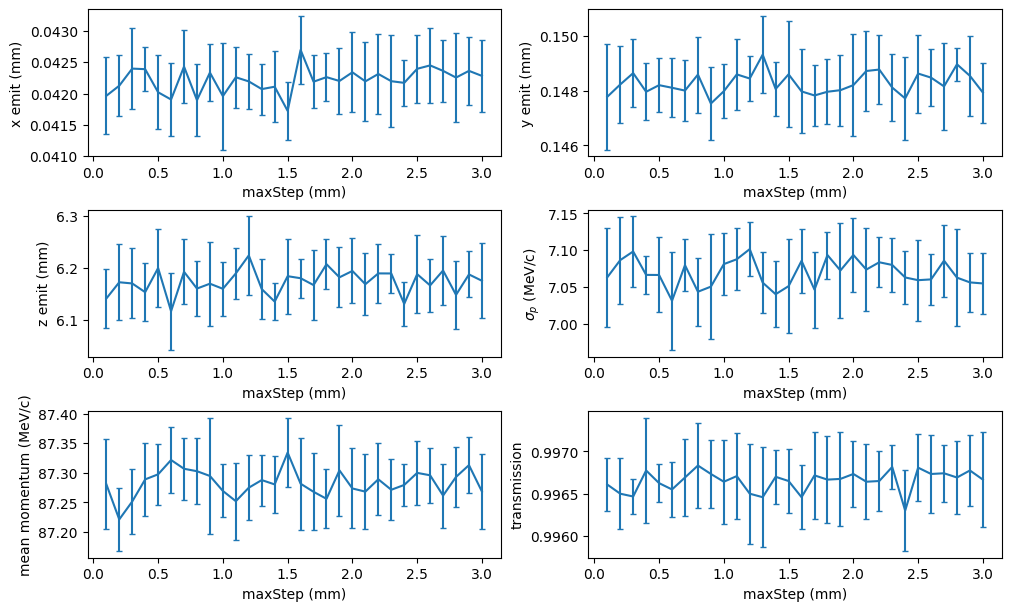

In [55]:
with lzma.open("results/wedge_max_step.pkl.lzma", "rb") as file:
    %time results = pickle.load(file)

maxSteps = np.linspace(0.1, 3, 30)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, layout="constrained")
fig.set_size_inches(10, 6)
ax1.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: emittances(cut_outliers(x))[0], results)), capsize=2)
ax1.set_xlabel(r"maxStep (mm)")
ax1.set_ylabel(r"x emit (mm)")

ax2.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: emittances(cut_outliers(x))[1], results)), capsize=2)
ax2.set_xlabel(r"maxStep (mm)")
ax2.set_ylabel(r"y emit (mm)")

ax3.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: emittances(cut_outliers(x))[2], results)), capsize=2)
ax3.set_xlabel(r"maxStep (mm)")
ax3.set_ylabel(r"z emit (mm)")

ax4.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: np.std(p_total(cut_outliers(x))), results)), capsize=2)
ax4.set_xlabel(r"maxStep (mm)")
ax4.set_ylabel(r"$\sigma_p$ (MeV/c)")

ax5.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: np.mean(p_total(cut_outliers(x))), results)), capsize=2)
ax5.set_xlabel(r"maxStep (mm)")
ax5.set_ylabel(r"mean momentum (MeV/c)")

ax6.errorbar(*qmap_to_arrays(maxSteps, calc_quantity(lambda x: len(cut_outliers(x))/12000, results)), capsize=2)
ax6.set_xlabel(r"maxStep (mm)")
ax6.set_ylabel(r"transmission")

# Study of accuracy parameters

Objective: Determine (with more trials) the effect of particle count, max step, and max step within the wedge on accuracy and computation time

In [16]:
particleCountRange = np.geomspace(1e4, 1e7, 30).astype(int)
maxStepRange = np.geomspace(0.01, 10, 30)
wedgeStepRange = np.geomspace(0.01, 10, 30)

In [17]:
load_params("results/parameters/145_new.pkl")

def fun(N):
    pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=N)
    pre_w1["PDGid"] = -13
    start_time = time.time()
    post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
    return post_w1, time.time()-start_time

results = run_scan(fun, (particleCountRange,), "results/particleCount_time_initial.pkl.lzma", trials=30)

Loaded from results/parameters/145_new.pkl


  2%|█▎                                                                             | 15/900 [04:43<4:38:46, 18.90s/it]


KeyboardInterrupt: 

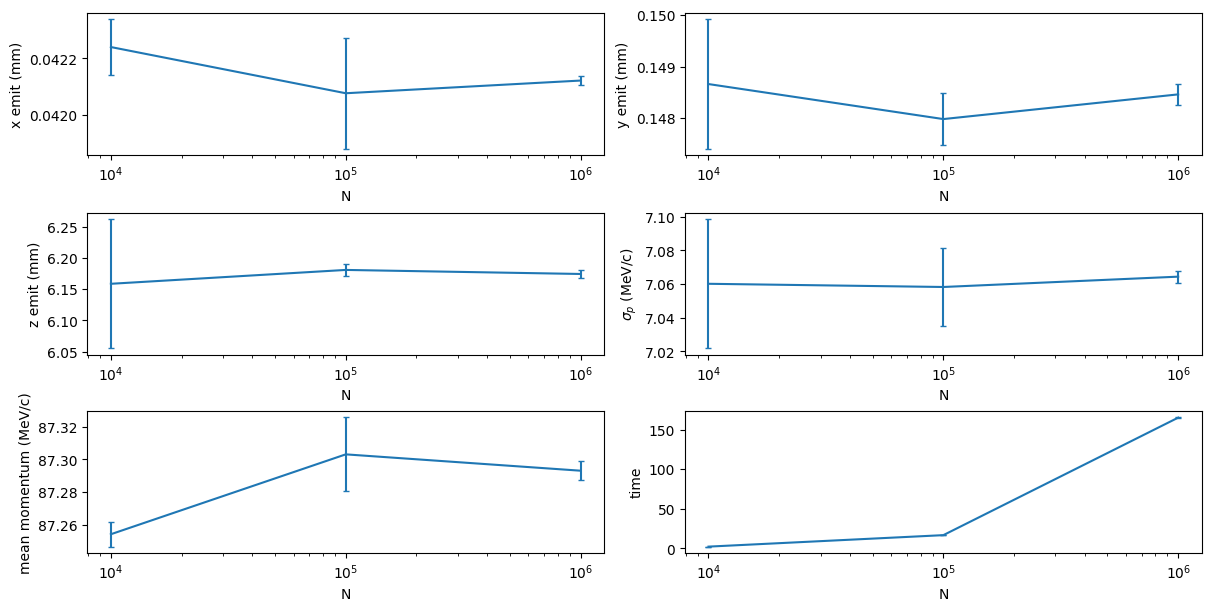

In [15]:
# with lzma.open("results/particleCount_time_initial.pkl.lzma", "rb") as file:
#     results = pickle.load(file)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, layout="constrained")
fig.set_size_inches(12, 6)
ax1.errorbar(*qmap_to_arrays(particleCountRange, calc_quantity(lambda x: emittances(cut_outliers(x[0]))[0], results)), capsize=2)
ax1.set_xlabel(r"N")
ax1.set_ylabel(r"x emit (mm)")
ax1.set_xscale("log")

ax2.errorbar(*qmap_to_arrays(particleCountRange, calc_quantity(lambda x: emittances(cut_outliers(x[0]))[1], results)), capsize=2)
ax2.set_xlabel(r"N")
ax2.set_ylabel(r"y emit (mm)")
ax2.set_xscale("log")

ax3.errorbar(*qmap_to_arrays(particleCountRange, calc_quantity(lambda x: emittances(cut_outliers(x[0]))[2], results)), capsize=2)
ax3.set_xlabel(r"N")
ax3.set_ylabel(r"z emit (mm)")
ax3.set_xscale("log")

ax4.errorbar(*qmap_to_arrays(particleCountRange, calc_quantity(lambda x: np.std(p_total(cut_outliers(x[0]))), results)), capsize=2)
ax4.set_xlabel(r"N")
ax4.set_ylabel(r"$\sigma_p$ (MeV/c)")
ax4.set_xscale("log")

ax5.errorbar(*qmap_to_arrays(particleCountRange, calc_quantity(lambda x: np.mean(p_total(cut_outliers(x[0]))), results)), capsize=2)
ax5.set_xlabel(r"N")
ax5.set_ylabel(r"mean momentum (MeV/c)")
ax5.set_xscale("log")

ax6.errorbar(*qmap_to_arrays(particleCountRange, calc_quantity(lambda x: x[1], results)), capsize=2)
ax6.set_xlabel(r"N")
ax6.set_ylabel(r"time")
ax6.set_xscale("log")